In [12]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

# 数据增强
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])
# CutMix函数
def cutmix(data, targets, alpha=1.0):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    targets = (targets, shuffled_targets, lam)

    return data, targets


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)  # 将 np.int 替换为 int
    cut_h = int(H * cut_rat)  # 将 np.int 替换为 int

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [13]:
import torchvision.models as models

cnn_model = models.resnet18(num_classes=100)
cnn_model = cnn_model.cuda()


In [14]:
from vit_pytorch import ViT

transformer_model = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 100,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)
transformer_model = transformer_model.cuda()


In [20]:
print(f'Number of parameters in CNN model: {cnn_params}')
print(f'Number of parameters in Transformer model: {transformer_params}')

Number of parameters in CNN model: 11227812
Number of parameters in Transformer model: 12719812


In [15]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# 超参数设置
learning_rate = 0.01
epochs = 50

# 定义优化器和损失函数
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
transformer_optimizer = optim.SGD(transformer_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# 训练和验证函数
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        progress_bar.set_postfix(loss=train_loss/(batch_idx+1), accuracy=100.*correct/total)
    return train_loss / len(train_loader), 100.*correct / total

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(test_loader, desc='Testing', leave=False)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            progress_bar.set_postfix(loss=test_loss/(batch_idx+1), accuracy=100.*correct/total)
    return test_loss / len(test_loader), 100.*correct / total


Epoch 1/50


CNN: Train Loss: 3.8593, Train Acc: 11.2760, Test Loss: 3.4501, Test Acc: 17.7800
Transformer: Train Loss: 4.3682, Train Acc: 4.1880, Test Loss: 4.0975, Test Acc: 7.5500
Epoch 2/50


CNN: Train Loss: 3.2719, Train Acc: 20.2400, Test Loss: 3.1076, Test Acc: 23.6900
Transformer: Train Loss: 3.8958, Train Acc: 10.2700, Test Loss: 3.5892, Test Acc: 15.5800
Epoch 3/50


CNN: Train Loss: 2.9718, Train Acc: 25.6160, Test Loss: 2.8099, Test Acc: 29.6700
Transformer: Train Loss: 3.4507, Train Acc: 17.5700, Test Loss: 3.2496, Test Acc: 21.8000
Epoch 4/50


CNN: Train Loss: 2.7577, Train Acc: 29.6060, Test Loss: 2.6248, Test Acc: 33.0700
Transformer: Train Loss: 3.1942, Train Acc: 22.1540, Test Loss: 3.0028, Test Acc: 26.0100
Epoch 5/50


CNN: Train Loss: 2.5824, Train Acc: 33.1400, Test Loss: 2.4890, Test Acc: 36.1300
Transformer: Train Loss: 3.0372, Train Acc: 24.8120, Test Loss: 2.8711, Test Acc: 28.4800
Epoch 6/50


CNN: Train Loss: 2.4457, Train Acc: 36.2180, Test Loss: 2.4314, Test Acc: 37.5400
Transformer: Train Loss: 2.9136, Train Acc: 27.3280, Test Loss: 2.7474, Test Acc: 30.2400
Epoch 7/50


CNN: Train Loss: 2.3326, Train Acc: 38.4240, Test Loss: 2.3695, Test Acc: 38.3500
Transformer: Train Loss: 2.8170, Train Acc: 29.0140, Test Loss: 2.6890, Test Acc: 32.2700
Epoch 8/50


CNN: Train Loss: 2.2302, Train Acc: 40.5680, Test Loss: 2.2840, Test Acc: 40.8500
Transformer: Train Loss: 2.7386, Train Acc: 30.9140, Test Loss: 2.6022, Test Acc: 33.7500
Epoch 9/50


CNN: Train Loss: 2.1389, Train Acc: 42.5280, Test Loss: 2.2808, Test Acc: 41.2400
Transformer: Train Loss: 2.6642, Train Acc: 32.3900, Test Loss: 2.5203, Test Acc: 35.5800
Epoch 10/50


CNN: Train Loss: 2.0553, Train Acc: 44.5240, Test Loss: 2.2065, Test Acc: 42.1500
Transformer: Train Loss: 2.6035, Train Acc: 33.3660, Test Loss: 2.4844, Test Acc: 36.3400
Epoch 11/50


CNN: Train Loss: 1.9804, Train Acc: 46.0080, Test Loss: 2.1761, Test Acc: 43.3800
Transformer: Train Loss: 2.5521, Train Acc: 34.5840, Test Loss: 2.4601, Test Acc: 36.8600
Epoch 12/50


CNN: Train Loss: 1.9040, Train Acc: 47.7380, Test Loss: 2.0978, Test Acc: 44.7900
Transformer: Train Loss: 2.5060, Train Acc: 35.5420, Test Loss: 2.3803, Test Acc: 38.0800
Epoch 13/50


CNN: Train Loss: 1.8427, Train Acc: 49.2540, Test Loss: 2.1339, Test Acc: 44.8200
Transformer: Train Loss: 2.4483, Train Acc: 36.6840, Test Loss: 2.4066, Test Acc: 38.0200
Epoch 14/50


CNN: Train Loss: 1.7896, Train Acc: 50.6500, Test Loss: 2.0863, Test Acc: 45.4200
Transformer: Train Loss: 2.4164, Train Acc: 37.1860, Test Loss: 2.3386, Test Acc: 39.8500
Epoch 15/50


CNN: Train Loss: 1.7185, Train Acc: 52.2480, Test Loss: 2.0596, Test Acc: 46.7600
Transformer: Train Loss: 2.3807, Train Acc: 38.1780, Test Loss: 2.2786, Test Acc: 40.7200
Epoch 16/50


CNN: Train Loss: 1.6679, Train Acc: 53.2040, Test Loss: 2.1123, Test Acc: 45.7800
Transformer: Train Loss: 2.3438, Train Acc: 39.0120, Test Loss: 2.2621, Test Acc: 41.5500
Epoch 17/50


CNN: Train Loss: 1.6136, Train Acc: 54.7380, Test Loss: 2.0715, Test Acc: 46.7200
Transformer: Train Loss: 2.3123, Train Acc: 39.3900, Test Loss: 2.2752, Test Acc: 41.3100
Epoch 18/50


CNN: Train Loss: 1.5738, Train Acc: 55.3220, Test Loss: 2.0670, Test Acc: 47.0900
Transformer: Train Loss: 2.2943, Train Acc: 39.9240, Test Loss: 2.2276, Test Acc: 42.3400
Epoch 19/50


CNN: Train Loss: 1.5202, Train Acc: 56.7780, Test Loss: 2.0180, Test Acc: 48.2200
Transformer: Train Loss: 2.2574, Train Acc: 40.7680, Test Loss: 2.2109, Test Acc: 42.8200
Epoch 20/50


CNN: Train Loss: 1.4602, Train Acc: 58.3060, Test Loss: 2.0228, Test Acc: 48.0800
Transformer: Train Loss: 2.2266, Train Acc: 41.1580, Test Loss: 2.2305, Test Acc: 41.7000
Epoch 21/50


CNN: Train Loss: 1.4104, Train Acc: 59.5740, Test Loss: 2.0170, Test Acc: 49.0500
Transformer: Train Loss: 2.2043, Train Acc: 41.8340, Test Loss: 2.1696, Test Acc: 43.5500
Epoch 22/50


CNN: Train Loss: 1.3758, Train Acc: 60.1460, Test Loss: 1.9986, Test Acc: 48.9900
Transformer: Train Loss: 2.1720, Train Acc: 42.4460, Test Loss: 2.1622, Test Acc: 43.5300
Epoch 23/50


CNN: Train Loss: 1.3303, Train Acc: 61.5380, Test Loss: 2.0284, Test Acc: 48.3800
Transformer: Train Loss: 2.1487, Train Acc: 43.0920, Test Loss: 2.1573, Test Acc: 44.2000
Epoch 24/50


CNN: Train Loss: 1.2843, Train Acc: 62.6760, Test Loss: 2.0131, Test Acc: 49.1100
Transformer: Train Loss: 2.1217, Train Acc: 43.4640, Test Loss: 2.1203, Test Acc: 44.6800
Epoch 25/50


CNN: Train Loss: 1.2441, Train Acc: 63.5340, Test Loss: 2.0513, Test Acc: 48.8600
Transformer: Train Loss: 2.0921, Train Acc: 44.4360, Test Loss: 2.0828, Test Acc: 45.0200
Epoch 26/50


CNN: Train Loss: 1.2087, Train Acc: 64.5620, Test Loss: 2.0570, Test Acc: 49.2600
Transformer: Train Loss: 2.0712, Train Acc: 44.8980, Test Loss: 2.0609, Test Acc: 45.6600
Epoch 27/50


CNN: Train Loss: 1.1629, Train Acc: 65.8280, Test Loss: 2.0298, Test Acc: 49.5100
Transformer: Train Loss: 2.0442, Train Acc: 45.3500, Test Loss: 2.0590, Test Acc: 45.9600
Epoch 28/50


CNN: Train Loss: 1.1197, Train Acc: 66.7320, Test Loss: 2.0533, Test Acc: 49.1000
Transformer: Train Loss: 2.0204, Train Acc: 45.9280, Test Loss: 2.0847, Test Acc: 45.4100
Epoch 29/50


CNN: Train Loss: 1.0861, Train Acc: 67.6420, Test Loss: 2.0620, Test Acc: 49.5700
Transformer: Train Loss: 1.9900, Train Acc: 46.5940, Test Loss: 2.0472, Test Acc: 45.5600
Epoch 30/50


CNN: Train Loss: 1.0471, Train Acc: 68.7300, Test Loss: 2.0270, Test Acc: 50.0900
Transformer: Train Loss: 1.9745, Train Acc: 46.7160, Test Loss: 2.0331, Test Acc: 46.0300
Epoch 31/50


CNN: Train Loss: 1.0194, Train Acc: 69.5600, Test Loss: 2.1093, Test Acc: 49.4100
Transformer: Train Loss: 1.9473, Train Acc: 47.2720, Test Loss: 1.9974, Test Acc: 46.6300
Epoch 32/50


CNN: Train Loss: 0.9798, Train Acc: 70.5280, Test Loss: 2.0832, Test Acc: 49.9900
Transformer: Train Loss: 1.9234, Train Acc: 47.7060, Test Loss: 2.0183, Test Acc: 46.9400
Epoch 33/50


CNN: Train Loss: 0.9437, Train Acc: 71.4440, Test Loss: 2.0951, Test Acc: 49.9300
Transformer: Train Loss: 1.8938, Train Acc: 48.5700, Test Loss: 2.0051, Test Acc: 47.3200
Epoch 34/50


CNN: Train Loss: 0.9110, Train Acc: 72.4540, Test Loss: 2.0933, Test Acc: 50.0400
Transformer: Train Loss: 1.8792, Train Acc: 48.8700, Test Loss: 1.9782, Test Acc: 47.4700
Epoch 35/50


CNN: Train Loss: 0.8863, Train Acc: 72.9700, Test Loss: 2.0836, Test Acc: 50.7100
Transformer: Train Loss: 1.8526, Train Acc: 49.4680, Test Loss: 1.9767, Test Acc: 47.8800
Epoch 36/50


CNN: Train Loss: 0.8464, Train Acc: 74.0880, Test Loss: 2.1024, Test Acc: 50.4200
Transformer: Train Loss: 1.8284, Train Acc: 50.0940, Test Loss: 1.9389, Test Acc: 48.6400
Epoch 37/50


CNN: Train Loss: 0.8234, Train Acc: 74.6920, Test Loss: 2.1719, Test Acc: 49.7100
Transformer: Train Loss: 1.7977, Train Acc: 50.8660, Test Loss: 1.9432, Test Acc: 48.9100
Epoch 38/50


CNN: Train Loss: 0.7860, Train Acc: 75.8880, Test Loss: 2.1464, Test Acc: 50.2800
Transformer: Train Loss: 1.7801, Train Acc: 51.2000, Test Loss: 1.9545, Test Acc: 48.5400
Epoch 39/50


CNN: Train Loss: 0.7557, Train Acc: 76.8080, Test Loss: 2.1968, Test Acc: 49.7600
Transformer: Train Loss: 1.7663, Train Acc: 51.2440, Test Loss: 1.9243, Test Acc: 49.1600
Epoch 40/50


CNN: Train Loss: 0.7279, Train Acc: 77.5560, Test Loss: 2.1698, Test Acc: 49.9900
Transformer: Train Loss: 1.7387, Train Acc: 51.9080, Test Loss: 1.9023, Test Acc: 49.4500
Epoch 41/50


CNN: Train Loss: 0.7099, Train Acc: 78.1000, Test Loss: 2.1610, Test Acc: 50.9400
Transformer: Train Loss: 1.7155, Train Acc: 52.7740, Test Loss: 1.9020, Test Acc: 49.7500
Epoch 42/50


CNN: Train Loss: 0.6764, Train Acc: 79.2040, Test Loss: 2.1766, Test Acc: 50.9000
Transformer: Train Loss: 1.6987, Train Acc: 53.0260, Test Loss: 1.8624, Test Acc: 50.7200
Epoch 43/50


CNN: Train Loss: 0.6624, Train Acc: 79.5600, Test Loss: 2.2431, Test Acc: 50.1500
Transformer: Train Loss: 1.6751, Train Acc: 53.7120, Test Loss: 1.8495, Test Acc: 51.2400
Epoch 44/50


CNN: Train Loss: 0.6352, Train Acc: 80.3100, Test Loss: 2.2154, Test Acc: 49.7700
Transformer: Train Loss: 1.6544, Train Acc: 54.1820, Test Loss: 1.8699, Test Acc: 51.4200
Epoch 45/50


CNN: Train Loss: 0.6105, Train Acc: 80.9560, Test Loss: 2.2531, Test Acc: 49.8200
Transformer: Train Loss: 1.6392, Train Acc: 54.1200, Test Loss: 1.9079, Test Acc: 49.0600
Epoch 46/50


CNN: Train Loss: 0.5870, Train Acc: 81.8680, Test Loss: 2.2045, Test Acc: 50.9000
Transformer: Train Loss: 1.6198, Train Acc: 54.4820, Test Loss: 1.8685, Test Acc: 51.2600
Epoch 47/50


CNN: Train Loss: 0.5637, Train Acc: 82.6280, Test Loss: 2.2606, Test Acc: 50.3300
Transformer: Train Loss: 1.6076, Train Acc: 55.0600, Test Loss: 1.8433, Test Acc: 51.1900
Epoch 48/50


CNN: Train Loss: 0.5533, Train Acc: 82.7940, Test Loss: 2.3115, Test Acc: 50.0400
Transformer: Train Loss: 1.5841, Train Acc: 55.3020, Test Loss: 1.8277, Test Acc: 51.5700
Epoch 49/50


CNN: Train Loss: 0.5417, Train Acc: 83.0720, Test Loss: 2.3115, Test Acc: 49.7800
Transformer: Train Loss: 1.5598, Train Acc: 56.2760, Test Loss: 1.8137, Test Acc: 52.1100
Epoch 50/50


CNN: Train Loss: 0.5135, Train Acc: 84.0080, Test Loss: 2.3115, Test Acc: 50.0200
Transformer: Train Loss: 1.5499, Train Acc: 56.5880, Test Loss: 1.8335, Test Acc: 51.5000


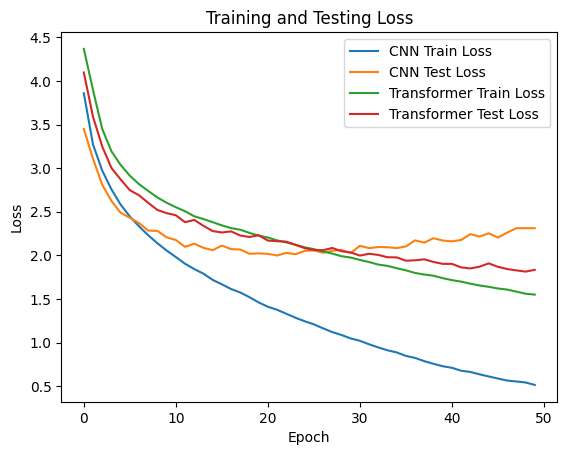

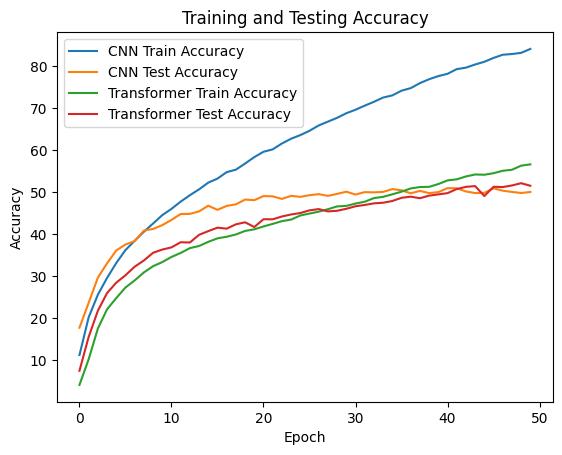

In [16]:
cnn_train_losses = []
cnn_train_accuracies = []
cnn_test_losses = []
cnn_test_accuracies = []

transformer_train_losses = []
transformer_train_accuracies = []
transformer_test_losses = []
transformer_test_accuracies = []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    cnn_train_loss, cnn_train_acc = train(cnn_model, train_loader, criterion, cnn_optimizer)
    cnn_test_loss, cnn_test_acc = test(cnn_model, test_loader, criterion)
    cnn_train_losses.append(cnn_train_loss)
    cnn_train_accuracies.append(cnn_train_acc)
    cnn_test_losses.append(cnn_test_loss)
    cnn_test_accuracies.append(cnn_test_acc)

    transformer_train_loss, transformer_train_acc = train(transformer_model, train_loader, criterion, transformer_optimizer)
    transformer_test_loss, transformer_test_acc = test(transformer_model, test_loader, criterion)
    transformer_train_losses.append(transformer_train_loss)
    transformer_train_accuracies.append(transformer_train_acc)
    transformer_test_losses.append(transformer_test_loss)
    transformer_test_accuracies.append(transformer_test_acc)

    print(f'CNN: Train Loss: {cnn_train_loss:.4f}, Train Acc: {cnn_train_acc:.4f}, Test Loss: {cnn_test_loss:.4f}, Test Acc: {cnn_test_acc:.4f}')
    print(f'Transformer: Train Loss: {transformer_train_loss:.4f}, Train Acc: {transformer_train_acc:.4f}, Test Loss: {transformer_test_loss:.4f}, Test Acc: {transformer_test_acc:.4f}')

# 绘制Loss曲线
plt.figure()
plt.plot(range(epochs), cnn_train_losses, label='CNN Train Loss')
plt.plot(range(epochs), cnn_test_losses, label='CNN Test Loss')
plt.plot(range(epochs), transformer_train_losses, label='Transformer Train Loss')
plt.plot(range(epochs), transformer_test_losses, label='Transformer Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

# 绘制Accuracy曲线
plt.figure()
plt.plot(range(epochs), cnn_train_accuracies, label='CNN Train Accuracy')
plt.plot(range(epochs), cnn_test_accuracies, label='CNN Test Accuracy')
plt.plot(range(epochs), transformer_train_accuracies, label='Transformer Train Accuracy')
plt.plot(range(epochs), transformer_test_accuracies, label='Transformer Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.show()
